# Wi-Fi IP Scaning Report

There is a Wi-Fi in the hotel I live, which is used by over 50 devices. Sometime I use that, I may be kicked out for too many connections to this Wi-Fi. It occured to me that I can collect these connections information to analyse daily schedules of people who live here. And I can find a way to also avoid using this Wi-Fi at the peak of connections' number.

This data is collected by an Android app.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import mac_producer
import time
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

%matplotlib inline

Read data from the file.

In [3]:

def preprocess(path):
    data = []
    mac_map = mac_producer.MAC_Map()
    with open(path) as f:
        s = f.readline()
        if len(s.split(' ')) >= 5:
            return
        while s:
            s = s[:-1]
            ip, mac, name, time = s.split(' ')
            data.append((ip, mac, name, time, mac_map.get_producer(mac)))
            s = f.readline()
    save_text = '\n'.join([' '.join(line) for line in data])
    with open(path, 'w', encoding='utf-8') as f:
        f.write(save_text)
            
def read(path):
    data = []
    with open(path) as f:
        s = f.readline()
        while s:
            s = s[:-1]
            data.append(s.split(' ', 4))
            s = f.readline()

    df = pd.DataFrame(data, columns=['ip', 'mac', 'name', 'time', 'producer'])
    df['hour'] = [time.gmtime(int(t)).tm_hour for t in df.time]
    df['minute'] = [time.gmtime(int(t)).tm_min for t in df.time]
    df['wday'] = [time.gmtime(int(t)).tm_wday for t in df.time]
    df['day_hour'] = df.hour + df.minute/60
    df['week_day'] = df.wday + df.day_hour/24
    return df

preprocess('./wifi_status.txt')
raw_df = read('./wifi_status.txt')

The format of this data is like the table following. 



Here is the columns:
- time. It is the time when this application found that connection. 
- name. It should be the name of that device. Here is a problem in that data.
- ip. Devices' IP addresses, assigned by the route. Most of it is useless for this report.
- mac. The MAC addresses of each devices, which are determined when birth, and should be unique in earth. Play key role in this report.

In [4]:
raw_df.head()

,ip,mac,name,time,producer,hour,minute,wday,day_hour,week_day
0,192.168.101.1,00:90:27:e0:d9:30,localhost,1505629299,Intel Corporation,6,21,6,6.35,6.264583
1,192.168.101.3,a8:66:7f:34:3a:3c,localhost,1505629299,"Apple, Inc.",6,21,6,6.35,6.264583
2,192.168.101.10,2c:1f:23:2d:ed:ef,localhost,1505629299,"Apple, Inc.",6,21,6,6.35,6.264583
3,192.168.101.16,80:13:82:d8:8b:71,localhost,1505629299,"HUAWEI TECHNOLOGIES CO.,LTD",6,21,6,6.35,6.264583
4,192.168.101.18,c4:d9:87:f4:70:90,localhost,1505629299,Intel Corporate,6,21,6,6.35,6.264583


Get the connections num by the raw data. And add diff layers of time data BTW.

In [5]:
def get_df_connections_time(raw_df):
    df = raw_df.groupby('time').count()
    df = pd.DataFrame({'time':df.index, 'n_connections':df.ip})
    df['hour'] = [time.gmtime(int(t)).tm_hour for t in df.time]
    df['minute'] = [time.gmtime(int(t)).tm_min for t in df.time]
    df['wday'] = [time.gmtime(int(t)).tm_wday for t in df.time]
    df['day_hour'] = df.hour + df.minute/60
    df['week_day'] = df.wday + df.day_hour/24
    # remove the error part (connections number == 1, suggest that this device just get kicked out)
    df = df.where(df.n_connections > 2).dropna()
    return df

df_ct = get_df_connections_time(raw_df)
display(df_ct.head())


,n_connections,time,hour,minute,wday,day_hour,week_day
time,,,,,,,
1505629299,32.0,1505629299,6.0,21.0,6.0,6.350000,6.264583
1505629320,16.0,1505629320,6.0,22.0,6.0,6.366667,6.265278
1505629339,27.0,1505629339,6.0,22.0,6.0,6.366667,6.265278
1505630166,28.0,1505630166,6.0,36.0,6.0,6.600000,6.275000
1505630408,27.0,1505630408,6.0,40.0,6.0,6.666667,6.277778


# Data Visualize

## Data Density


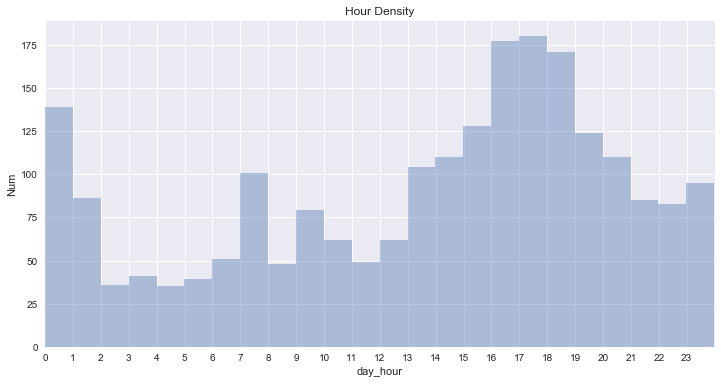

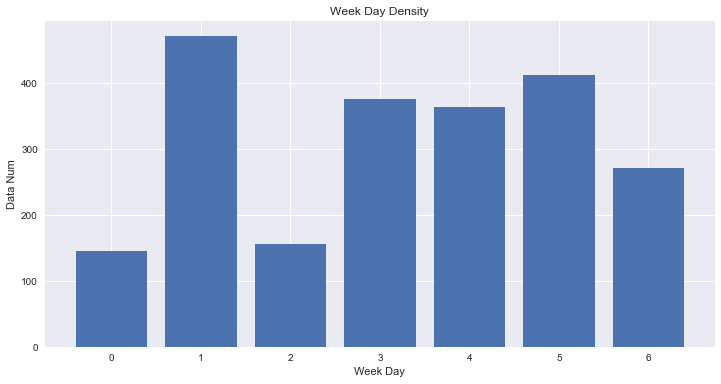

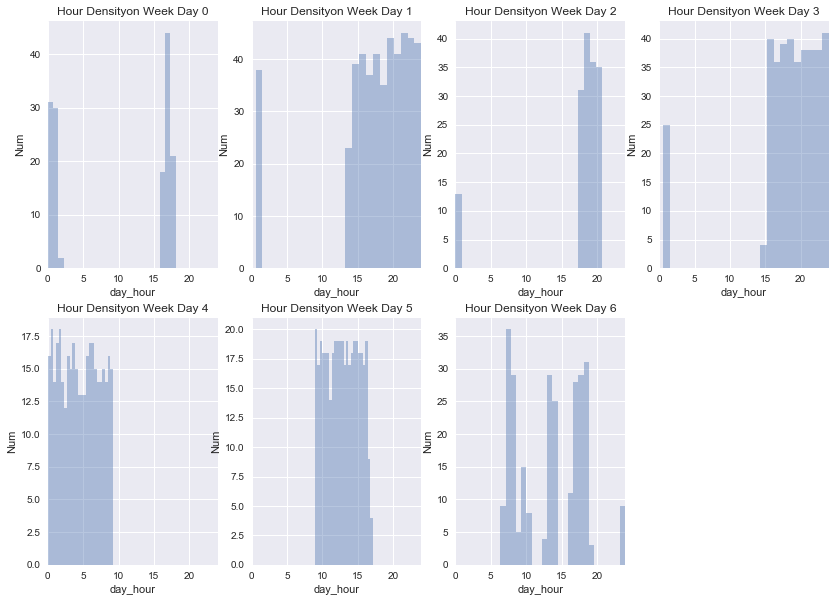

In [6]:
def plot_hour_density(df, name='', ax=None):
    if ax is None:
        fig = plt.figure(figsize=(12, 6))
    plt.title('Hour Density' + name)
    plt.xlim((0, 24))
    if ax is None:
        plt.xticks([i for i in range(24)])
    plt.xlabel('Hour')
    plt.ylabel('Num')
    if ax is None:
        ax = plt.subplot(111)
    sns.distplot(df.day_hour, ax=ax, bins=24, kde=False)

def plot_weekday_density(df):
    temp = df.groupby('wday').count().hour
    fig = plt.figure(figsize=(12, 6))
    plt.title('Week Day Density')
    plt.xticks([i for i in range(7)])
    plt.xlabel('Week Day')
    plt.ylabel('Data Num')
    ax = plt.subplot(111)
    plt.bar(list(range(7)), temp.values)
    
plot_hour_density(df_ct)
plot_weekday_density(df_ct)
plt.figure(figsize=(14, 10))
for i in range(7):
    ax = plt.subplot(2, 4, i + 1)
    df = df_ct.loc[(df_ct.week_day // 1) == i]
    plot_hour_density(df, name="on Week Day " + str(i), ax=ax)

## Daily Change


The plot below shows average trend of the number of connections during a day in the data. As you can see below, the number of connections reach peak at 5pm, and most of them disconnected at 3am to 7am. And 8am is an interesting point, when a part of people wake up and go to work, and in 8:30 the number reachs the bottom again, which makes sense.

However, here comes the questions:

1. Why should it reach peak at 17:00? 
2. Why does it increace from 9am till 5pm?
3. Why does it fall down rapidly from 5pm to 6pm? 
4. Who are the dozen of people that leave during 5pm to 6pm? When do they connect to the WiFi?
5. Who are the dozen of people that leave during 7pm to 9pm? What do their daily schedules look like?
6. Who are the people sleep very late? What's their daily schedules look like?
7. Which devices conneted to the Wi-Fi all the time?

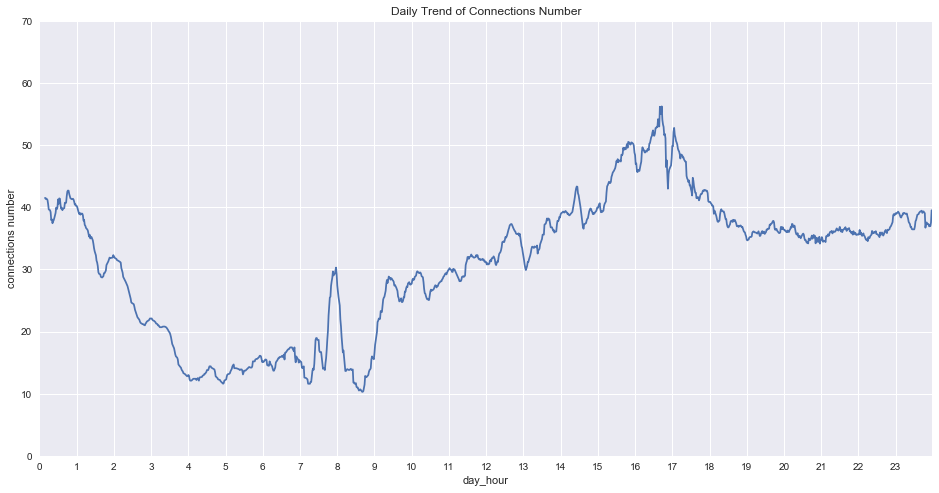

In [7]:
plt.figure(figsize=(16, 8))
plt.title('Daily Trend of Connections Number')
plt.ylabel('connections number')
plt.ylim((0, 70))
plt.xticks([i for i in range(24)])
conn_day_change = df_ct.groupby('day_hour').mean().n_connections
day_trend = conn_day_change.rolling(10).mean()
day_trend.plot()


## Weekly Trend

This is the plot to demonstrate the connections number change during a week. Obviously this should be sample at the same time windows in a day. Since the data I collected here is not continuous, plotting directly make no sense. 

It seems like a good way to substract the average daily trend from the data of every week day. In this way, we can remove the daily cycle of the data.

With these, I can solve those questions:

1. Who go out at weekend?
2. Who come here at weekend?
3. Are there ones who stay here all the week? (except for the long last connected ones)

### Raw Plot

This is the directly plot of everyday connections number change. As you can see, this plot does not make much sense. Because there are daily change in it which affect the result.

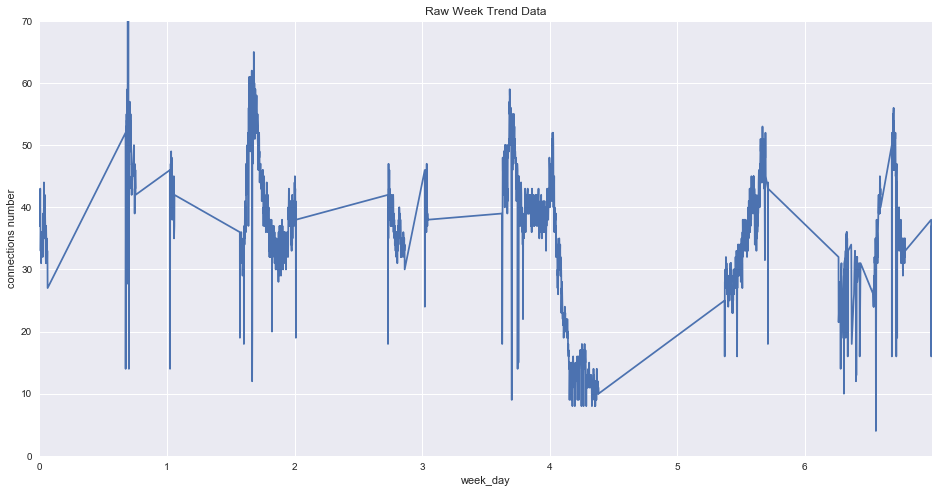

In [8]:
plt.figure(figsize=(16, 8))
plt.ylabel('connections number')
plt.ylim((0, 70))
plt.xticks([i for i in range(7)])
plt.title('Raw Week Trend Data')
weekday_trend = df_ct.groupby('week_day').mean().n_connections
weekday_trend.plot()



### Remove the Daily Trend from the Weekly Trend

The results are showing below. The first plot is the daily trend in one week day substract the average daily trend. Because the data is not enough, you might see a lot of gaps in there.

The second plot is the average change of connections number on one day in a week. You can see the change is so small. That's because the data I collect is not enough, the on one day of a week will be very similar to the average daily trend at the corresponding time. If I collect more data, this reasonable weekly trend will make more sense.

#### Time Granularity = 1 min

<Container object of 7 artists>

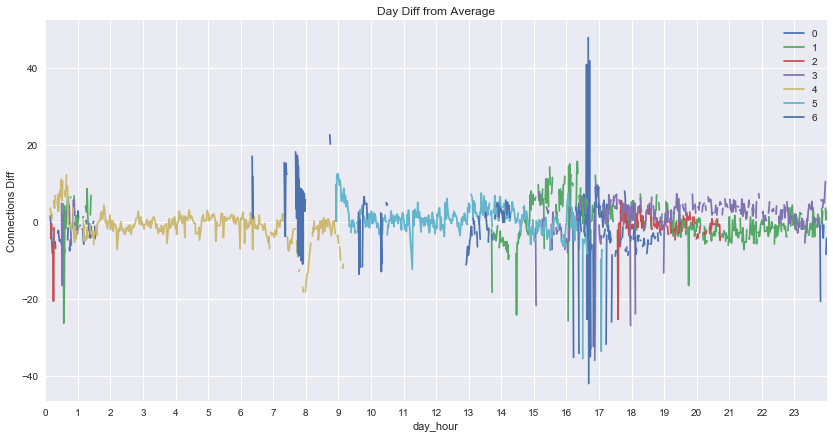

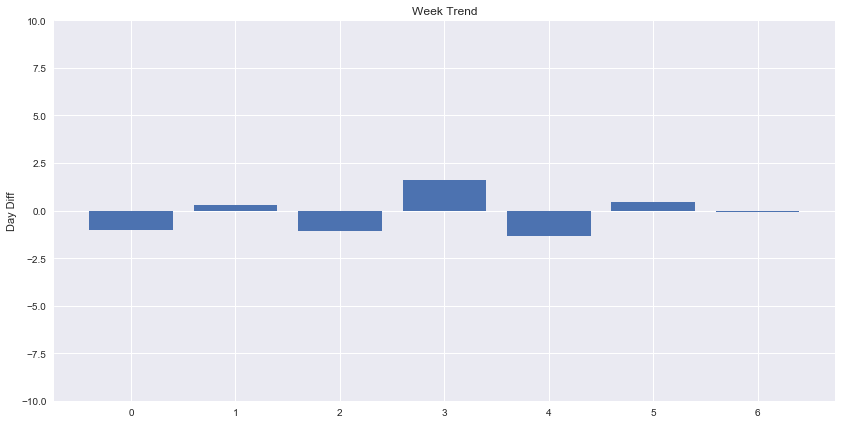

In [9]:
plt.figure(figsize=(14, 7))
plt.title('Day Diff from Average')
plt.ylabel('Connections Diff')
plt.xticks(list(range(24)))
week_day_mean = []
for i in range(7):
    df = df_ct.loc[df_ct.wday == i]
    df.index = df.day_hour
    day_diff = df.n_connections - day_trend
    week_day_mean.append(day_diff.mean())
    day_diff.plot()
plt.legend(list(range(7)))

plt.figure(figsize=(14, 7))
plt.title('Week Trend')
plt.ylabel('Day Diff')
plt.ylim((-10, 10))
plt.bar(list(range(7)), week_day_mean)

#### Time Granularity = 1 hour

A bigger size of granularity would reduce the need of data here, but it may be a little more untrustworthy.

The result is shown as below

<Container object of 7 artists>

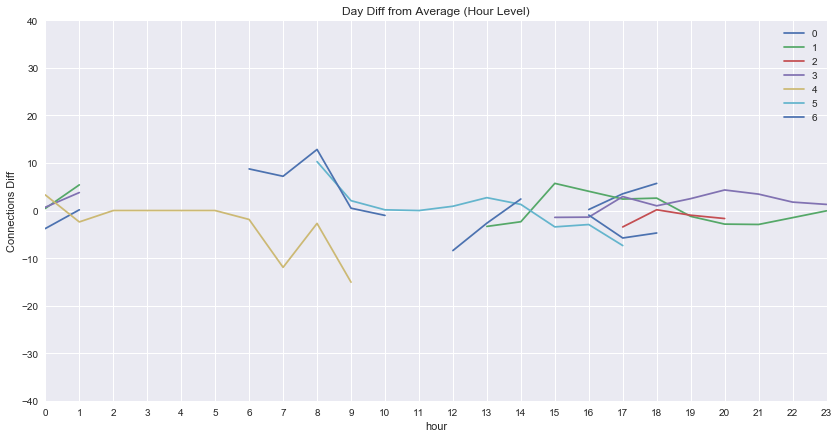

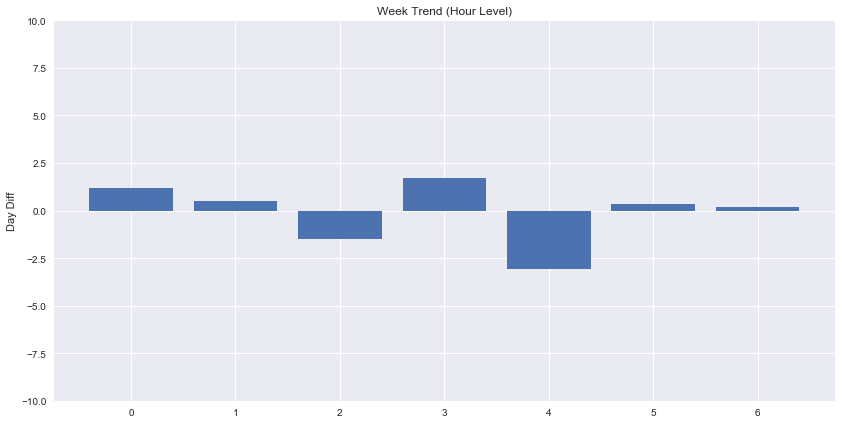

In [10]:
day_hour_trend = df_ct.groupby('hour').mean().n_connections
plt.figure(figsize=(14, 7))
plt.title('Day Diff from Average (Hour Level)')
plt.ylabel('Connections Diff')
plt.xticks(list(range(24)))
plt.ylim((-40, 40))
week_day_mean = []
for i in range(7):
    df = df_ct.loc[df_ct.wday == i]
    df = df.groupby('hour').mean().n_connections
    day_diff = df - day_hour_trend
    week_day_mean.append(day_diff.mean())
    day_diff.plot()
plt.legend(list(range(7)))

plt.figure(figsize=(14, 7))
plt.title('Week Trend (Hour Level)')
plt.ylabel('Day Diff')
plt.ylim((-10, 10))
plt.bar(list(range(7)), week_day_mean)

# Indivisual Tracking

The analysis in this section aim to solve the questions described above.

#### Who are the dozen of people that leave during 5pm to 6pm? When do they connect to the WiFi?

1. Find out who disconnected and connected to the wifi at a time point
2. Create a method get_connecte_devices(start_time, end_time) & dis
3. Create a method get_connect_time(MACs) & dis